In [1]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt # for figures
%matplotlib inline

In [2]:
# read words
words = open('names.txt','r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [76]:
# build vocab and mappings to/from ints
vocab = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(vocab)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(vocab)+1

In [4]:
# build dataset

block_size = 3 # ctx length

def build_dataset(words):
    X,Y = [],[]
    
    for w in words:
        context = [0]*block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X,Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

random.shuffle(words)
n = len(words)
n1,n2  = int(0.8*n),int(0.9*n)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182435, 3]) torch.Size([182435])
torch.Size([22840, 3]) torch.Size([22840])
torch.Size([22871, 3]) torch.Size([22871])


In [5]:
# utility func to compare manual grads to pytorch grads
def cmp(s, dt, t):
    ex = torch.all(dt==t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt-t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')
    

In [6]:
n_embd = 10 # dimensionality of char embedding vectors
n_hidden = 64 # num of hidden neurons

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size,n_embd), generator = g)
#Layer 1
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3) / ((n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden, generator = g) * 0.1 # just to check grad
# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
# batchNorm params
bngain = torch.randn((1,n_hidden), generator =g ) * 0.1 + 1.0
bnbias = torch.randn((1,n_hidden))*0.1

# non standard init for just check grads as zero vals can mask incorect gradients

parameters = [C,W1,b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # total params
for p in parameters:
    p.requires_grad = True

4137


In [7]:
batch_size = 32
n = batch_size # shorter var size for convenice
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0],(batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [8]:
# forward pass, chunked into smaller steps to backward one at a time

emb = C[Xb] # embed char into vectors
embcat = emb.view(emb.shape[0],-1) # concat 
# linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre activation
# batch norm layer
bnmeani = 1/n*hprebn.sum(0,keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0,keepdim=True) # bessel's correction n-1 not n
bnvar_inv = (bnvar+1e-5)**-0.5
bnraw = bndiff*bnvar_inv
hpreact = bngain*bnraw + bnbias
# non-linearity
h = torch.tanh(hpreact) # hidden layer tanh
# linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same F.cross_entropy)
logit_maxes = logits.max(1,keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1,keepdim=True) # 32x37 => 32x1
counts_sum_inv = counts_sum**-1 # doing 1/count_sum wouldn't be exact for backprop
probs = counts * counts_sum_inv # 32x27, 32x1
logprobs = probs.log()
loss = -logprobs[range(n),Yb].mean()

# pytorch backward pass
for p in parameters:
    p.grad=None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
         norm_logits, logit_maxes, logits, h, hpreact, bnraw, 
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.4609, grad_fn=<NegBackward0>)

In [9]:
logits.shape, h.shape, W2.shape

(torch.Size([32, 27]), torch.Size([32, 64]), torch.Size([64, 27]))

In [32]:
# Ex 1 : do the whole backprop thing manually 

# loss = -logprobs[range(n),Yb].mean()
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n),Yb] = -1.0/n

dlogprobs_probs = probs**-1
dprobs = dlogprobs_probs * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1,keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = - (counts_sum**-2) * dcounts_sum_inv
dcounts += dcounts_sum.broadcast_to(counts.shape)
# dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1,keepdim=True)
dlogits += F.one_hot(logits.max(1).indices,num_classes = logits.shape[1]) * dlogit_maxes

# logits = h @ W2 + b2
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0) # broadcasted across rows (replicated vertically)

# h = torch.tanh(hpreact)
dhpreact = (1.0-h**2)*dh

# hpreact = bngain*bnraw + bnbias
dbngain = (bnraw*dhpreact).sum(0,keepdim=True)
dbnraw = bngain*dhpreact
dbnbias = dhpreact.sum(0)

# bnraw = bndiff*bnvar_inv
dbndiff = bnvar_inv*dbnraw
dbnvar_inv = (bndiff*dbnraw).sum(0,keepdim=True)

# bnvar_inv = (bnvar+1e-5)**-0.5
dbnvar = -0.5 * (bnvar+1e-5)**(-1.5) * dbnvar_inv

# bnvar = 1/(n-1)*(bndiff2).sum(0,keepdim=True)
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff2 = (1.0/(n-1)) * dbnvar.broadcast_to(bndiff2.shape)

# bndiff2 = bndiff**2
dbndiff += 2* bndiff * dbndiff2

# bndiff = hprebn - bnmeani
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0,keepdim=True)

# bnmeani = 1/n*hprebn.sum(0,keepdim=True)
dhprebn += (1.0/n)*dbnmeani.broadcast_to(hprebn.shape)

# hprebn = embcat @ W1 + b1
db1 = dhprebn.sum(0)
dW1 = embcat.T @ dhprebn
dembcat = dhprebn @ W1.T

# embcat = emb.view(emb.shape[0],-1)
demb = dembcat.reshape(emb.shape)

# emb = C[Xb]
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix]+=demb[k,j]


cmp('logprobs',dlogprobs, logprobs)
cmp('probs',dprobs, probs)
cmp('counts_sum_inv',dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum',dcounts_sum, counts_sum)
cmp('counts',dcounts, counts)
cmp('norm_logits',dnorm_logits, norm_logits)
cmp('logit_maxes',dlogit_maxes, logit_maxes)
cmp('logits',dlogits,logits)
cmp('db2', db2, b2)
cmp('dh',dh,h)
cmp('dW2',dW2,W2)
cmp('dhpreact',dhpreact,hpreact)
cmp('dbnbias',dbnbias,bnbias)
cmp('dbngain',dbngain,bngain)
cmp('dbnraw',dbnraw,bnraw)
cmp('dbnvar_inv',dbnvar_inv,bnvar_inv)
cmp('dbnvar',dbnvar,bnvar)
cmp('dbndiff2',dbndiff2,bndiff2)
cmp('dbndiff',dbndiff,bndiff)
cmp('dbnmeani',dbnmeani,bnmeani)
cmp('dhprebn',dhprebn,hprebn)
cmp('db1',db1,b1)
cmp('dW1',dW1,W1)
cmp('dembcat',dembcat,embcat)
cmp('demb',demb,emb)
cmp('dC',dC, C)




logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
db2             | exact: True  | approximate: True  | maxdiff: 0.0
dh              | exact: True  | approximate: True  | maxdiff: 0.0
dW2             | exact: True  | approximate: True  | maxdiff: 0.0
dhpreact        | exact: True  | approximate: True  | maxdiff: 0.0
dbnbias         | exact: True  | approximate: True  | maxdiff: 0.0
dbngain         | exact: True  | approximate: True  | maxdiff: 0.0
dbnraw          | exact: True  | approximate: True  | maxdiff:

In [20]:
hprebn.shape, embcat.shape, W1.shape, b1.shape

(torch.Size([32, 64]),
 torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]))

In [30]:
emb.shape, C.shape, Xb.shape

(torch.Size([32, 3, 10]), torch.Size([27, 10]), torch.Size([32, 3]))

In [35]:
# Ex 2: backprop throgh cross_entropy in one go
# take derivative of loss wrt logits

# forwad pass 
# before
# logit_maxes = logits.max(1,keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1,keepdim=True) # 32x37 => 32x1
# counts_sum_inv = counts_sum**-1 # doing 1/count_sum wouldn't be exact for backprop
# probs = counts * counts_sum_inv # 32x27, 32x1
# logprobs = probs.log()
# loss = -logprobs[range(n),Yb].mean()

# Now:
loss_fast = F.cross_entropy(logits,Yb)
print(loss_fast.item(), loss.item(), 'diff: ', (loss_fast-loss).item())

3.460947036743164 3.460947036743164 diff:  0.0


In [37]:
# backward pass
dlogits = F.softmax(logits,1)
dlogits[range(n),Yb] -= 1
dlogits /= n

cmp('dlogits', dlogits,logits)

dlogits         | exact: False | approximate: True  | maxdiff: 4.889443516731262e-09


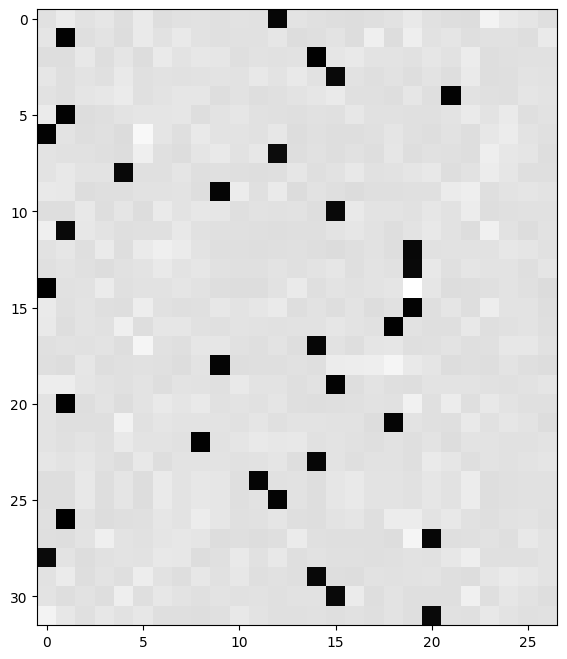

In [40]:
# What is dlogits?
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray');

In [42]:
# Exercise 3: backprop through batchnorm layer but all in one go
# look at exp for batchnorm and take deriv wrt its input

# forward pass
# before:
# bnmeani = 1/n*hprebn.sum(0,keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0,keepdim=True) # bessel's correction n-1 not n
# bnvar_inv = (bnvar+1e-5)**-0.5
# bnraw = bndiff*bnvar_inv
# hpreact = bngain*bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0,keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max_diff: ', (hpreact_fast-hpreact).abs().max())

max_diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [43]:
# backward pass
# dbngain = (bnraw*dhpreact).sum(0,keepdim=True)
# dbnraw = bngain*dhpreact
# dbnbias = dhpreact.sum(0)

# # bnraw = bndiff*bnvar_inv
# dbndiff = bnvar_inv*dbnraw
# dbnvar_inv = (bndiff*dbnraw).sum(0,keepdim=True)

# # bnvar_inv = (bnvar+1e-5)**-0.5
# dbnvar = -0.5 * (bnvar+1e-5)**(-1.5) * dbnvar_inv

# # bnvar = 1/(n-1)*(bndiff2).sum(0,keepdim=True)
# # dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff2 = (1.0/(n-1)) * dbnvar.broadcast_to(bndiff2.shape)

# # bndiff2 = bndiff**2
# dbndiff += 2* bndiff * dbndiff2

# # bndiff = hprebn - bnmeani
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0,keepdim=True)

# # bnmeani = 1/n*hprebn.sum(0,keepdim=True)
# dhprebn += (1.0/n)*dbnmeani.broadcast_to(hprebn.shape)

dhprebn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) -n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
cmp('dhprebn',dhprebn, hprebn)
 

dhprebn         | exact: False | approximate: True  | maxdiff: 1.1641532182693481e-09


In [79]:
# Ex 4 : Train using manual steps

n_embd = 10 # dimensionality of char embedding vectors
n_hidden = 200 # num of hidden neurons

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size,n_embd), generator = g)
#Layer 1
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3) / ((n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden, generator = g) * 0.1 # just to check grad
# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
# batchNorm params
bngain = torch.randn((1,n_hidden), generator =g ) * 0.1 + 1.0
bnbias = torch.randn((1,n_hidden))*0.1

# non standard init for just check grads as zero vals can mask incorect gradients

parameters = [C,W1,b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # total params
for p in parameters:
    p.requires_grad = True

batch_size = 32
n = batch_size # shorter var size for convenice
max_steps = 200000
lossi = []
with torch.no_grad():
    for i in range(max_steps):
        # construct a minibatch
        ix = torch.randint(0, Xtr.shape[0],(batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]

        # forward pass, chunked into smaller steps to backward one at a time

        emb = C[Xb] # embed char into vectors
        embcat = emb.view(emb.shape[0],-1) # concat 
        # linear layer 1
        hprebn = embcat @ W1 + b1 # hidden layer pre activation
        # batch norm layer
        bnmean = hprebn.mean(0,keepdim=True)
        bnvar = hprebn.var(0,keepdim=True)
        bnvar_inv = (bnvar+1e-5)**-0.5
        bnraw = (hprebn-bnmean)*bnvar_inv
        hpreact = bngain*bnraw + bnbias
        # non-linearity
        h = torch.tanh(hpreact) # hidden layer tanh
        # linear layer 2
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits,Yb)
        if i%10000==0:    
            print(i, loss)

        # pytorch backward pass
        for p in parameters:
            p.grad=None
#         loss.backward()
        # loss

        dlogits = F.softmax(logits,1)
        dlogits[range(n),Yb] -= 1
        dlogits /= n

        # 2nd layer backprop
        # logits = h @ W2 + b2
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0) # broadcasted across rows (replicated vertically)

        # h = torch.tanh(hpreact)
        dhpreact = (1.0-h**2)*dh

        # Batchnorm backprop
        dbngain = (bnraw*dhpreact).sum(0,keepdim=True)
        dbnbias = dhpreact.sum(0)

        dhprebn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) -n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

        # hprebn = embcat @ W1 + b1
        db1 = dhprebn.sum(0)
        dW1 = embcat.T @ dhprebn
        dembcat = dhprebn @ W1.T

        # embcat = emb.view(emb.shape[0],-1)
        demb = dembcat.reshape(emb.shape)

        # emb = C[Xb]
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k,j]
                dC[ix]+=demb[k,j]
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
        
        # update
        lr = 0.1 if i<max_steps/2 else 0.01 # step lr decay
        for p, grad in zip(parameters, grads):
            p.data += -lr * grad
            
#         for p,z in zip(parameters,grads):
#             cmp(str(tuple(p.shape)),z,p)
            
        lossi.append(loss.log().item())
        


12297
0 tensor(3.6209)
10000 tensor(2.4809)
20000 tensor(1.8566)
30000 tensor(2.3609)
40000 tensor(1.9766)
50000 tensor(1.9988)
60000 tensor(1.9970)
70000 tensor(2.5475)
80000 tensor(1.9352)
90000 tensor(1.7701)
100000 tensor(2.4469)
110000 tensor(2.3137)
120000 tensor(2.1310)
130000 tensor(1.9865)
140000 tensor(2.3196)
150000 tensor(1.9866)
160000 tensor(2.3695)
170000 tensor(1.9863)
180000 tensor(2.2959)
190000 tensor(2.7086)


In [80]:
with torch.no_grad():
    # pass the training set
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat@W1 + b1
    # measure mean/std
    bnmean = hpreact.mean(0,keepdim=True)
    bnvar = hpreact.var(0,keepdim=True, unbiased=True)
    

In [81]:
# evaluate train and val loss

@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val' : (Xdev,Ydev),
        'test' : (Xte,Yte),
    }[split]
    emb = C[x]
    hpreact = emb.view(emb.shape[0],-1)@W1 + b1
    hpreact = bngain *(hpreact-bnmean)*(bnvar+1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact)
    logits = h@W2 + b2
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())
split_loss('train')
split_loss('val')

train 2.0707921981811523
val 2.118593215942383


In [82]:
# Sample from the dataset

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # ...
    while True:
        
        emb = C[torch.tensor([context])] # 1xblock_sizexD
        hpreact = emb.view(emb.shape[0],-1)@W1 + b1
        hpreact = bngain *(hpreact-bnmean)*(bnvar+1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact)
        logits = h@W2 + b2
        
        # Sample
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples=1, generator=g).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix==0:
            break
            
    print(''.join(itos[i] for i in out))

carman.
ambril.
khi.
mili.
taty.
skaan.
kenleine.
farliyat.
kaeli.
nellara.
chaiiv.
kaleigh.
ham.
joce.
quint.
suline.
liven.
corathon.
jarinix.
kaellinsley.
